In [1]:
import pandas as pd                                                                
import numpy as np                                                                 
import matplotlib.pyplot as plt                                                    
from sklearn.neighbors import KNeighborsRegressor                                  
from Convolution import Convolution                                                
import seaborn as sns                                                              
sns.set()                                                                         
from ipywidgets import interact, interactive, HBox, Label, IntSlider, widgets, FloatSlider, interactive_output, VBox

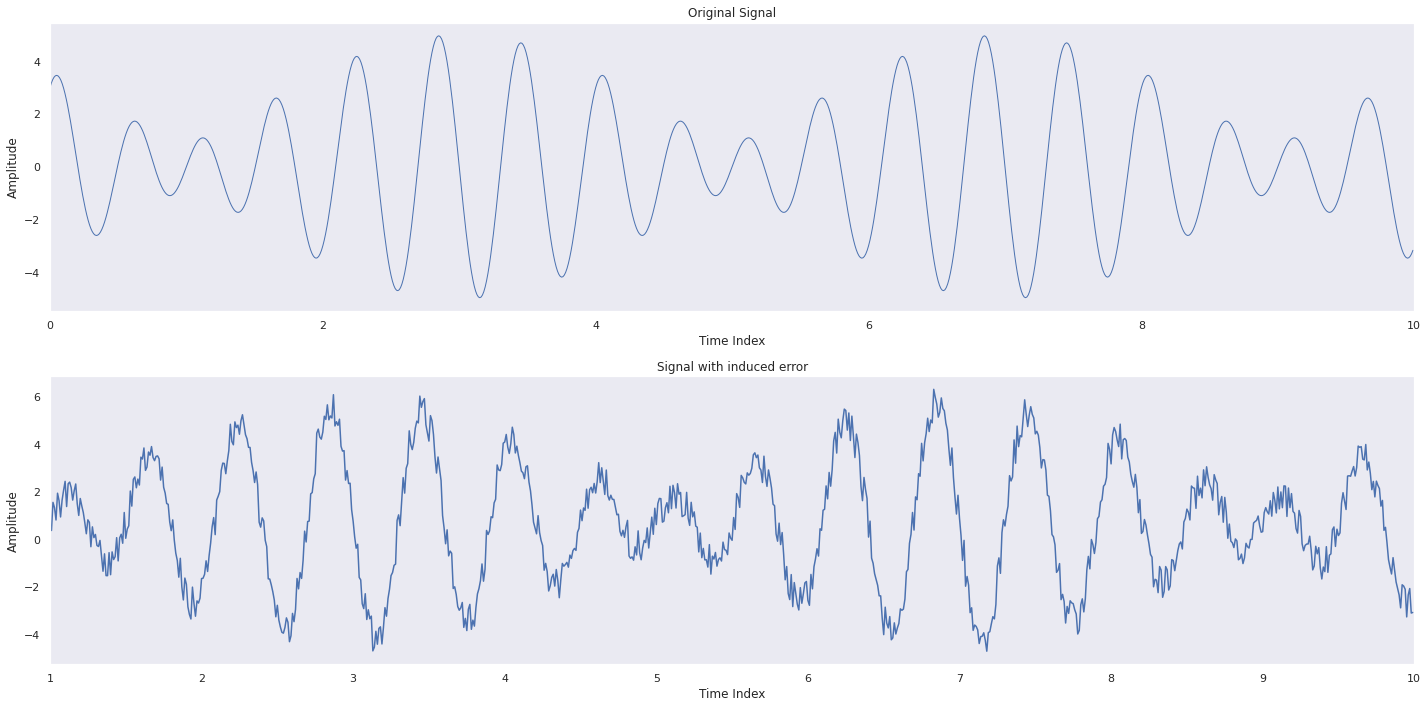

In [2]:
#generating signal                                                                 
t = np.arange(0,10, 0.01)                                                          
orig_signal = 2 *np.sin(2 * np.pi * 1.5 * t) + 3 * np.cos(2 * np.pi * 1.75 * t)    
err = np.random.rand(len(t))                                                       
signal = orig_signal + err * 1.5                                                   
fig, ax = plt.subplots(nrows = 2, figsize=(20, 10))                                                  
ax[0].plot(t, orig_signal, linewidth=1)                                            
ax[0].set_title('Original Signal')                                                 
ax[0].set_xlabel("Time Index")                                                     
ax[0].set_ylabel('Amplitude')                                                      
ax[0].grid()                                                                       
ax[0].set_xlim(0, 10)                                                              
ax[1].plot(t, signal)                                                              
ax[1].set_title('Signal with induced error')                                       
ax[1].set_xlabel("Time Index")                                                     
ax[1].set_ylabel('Amplitude')                                                      
ax[1].grid()                                                                       
ax[1].set_xlim(1, 10)                                                              
fig.tight_layout()                                                                 
plt.show() 

In [3]:
#just for capturing standard deviation of the signal.
default_window_len = 15

#function to plot convoluted signal 
def interactive_plot(window, err_mul = 1, win_len=10):                                       
    t = np.arange(0, 10 , 0.01)                                                    
    orig_signal = 2 *np.sin(2 * np.pi * 1.5 * t) + 3 * np.cos(2 * np.pi * 1.75 * t)
    np.random.seed(69)
    error = np.random.rand(len(t))                                                 
    signal = orig_signal + error * err_mul                              
    conv_obj = Convolution()                                                       
    out_signal = conv_obj.convolute(window, win_len, signal)                 
    signal = pd.Series(signal)
    fig, ax = plt.subplots(nrows=1, figsize=(25,10))                                                
    ax.fill_between(t, signal+signal.rolling(default_window_len).std(), signal-signal.rolling(default_window_len).std(), facecolor='lightseagreen',alpha=0.5, label='Signal')
    ax.plot(t, out_signal, color='black', label='Convoluted Signal')
    ax.legend()
    ax.set_xlim(0,10)
    ax.set_title("Using Convolution")
    plt.show()

In [4]:
errslider = widgets.FloatSlider(min=0.00, max=3.00,step= 0.01, value=1.00)
winslider = widgets.IntSlider(min=3, max=100, step=1, value=10)
windlist = widgets.Dropdown(options=['flat', 'hanning', 'hamming', 'blackman', 'bartlett'], value='flat')
hbox1 = widgets.HBox([Label('WINDOW LENGTH:'), winslider])
hbox2 = widgets.HBox([Label('ERROR MULTIPLIER:'), errslider])
hbox3 = widgets.HBox([Label('WINDOW:'), windlist])
HBOX1 = VBox([hbox1, hbox2])
ui = HBox([HBOX1, hbox3])
#display(ui)

In [5]:
out = interactive_output(interactive_plot, {'err_mul':errslider, 'win_len':winslider, 'window':windlist})
display(ui, out)

Output()